In [1]:
#Data set
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

pickle.dump(X,open('dataX.pickle','wb'))
pickle.dump(y,open('dataY.pickle','wb'))

In [2]:
#Partition
from sklearn.model_selection import train_test_split
data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split(X, y, test_size=0.20)
print (" Training Dataset X Shape : ",data_X_train.shape)
print (" Test Dataset X Shape : ",data_X_test.shape)
print (" Training Dataset Y Shape : ",data_Y_train.shape)
print (" Test Dataset Y Shape : ",data_Y_test.shape)

 Training Dataset X Shape :  (240, 2)
 Test Dataset X Shape :  (60, 2)
 Training Dataset Y Shape :  (240,)
 Test Dataset Y Shape :  (60,)


In [6]:
def ffnl(X,y,s,r,g_iter):
    #For simplicity we will take the batch size to be the same as number of examples
    num_examples = X.shape[0]
    h = 100
    np.random.seed(1234)
    W = 0.01 * np.random.randn(D,h)
    b = np.zeros((1,h))
    W2 = 0.01 * np.random.randn(h,K)
    b2 = np.zeros((1,K))
    
    #Initial value for the Gradient Descent Parameter
    step_size = s #Also called learning rate

    #For simplicity, we will not hand tune this algorithm parameter as well.
    reg= r
    
    # gradient descent loop
    for i in range(g_iter):
      
  # evaluate class scores, [N x K]
        #hidden_layer = np.maximum(0.01*x, np.dot(X, W) + b)# note, ReLU activation
        hidden_layer = np.maximum(np.dot(0.01*X,W)+b  , np.dot(X,W)+ b) # Leaky ReLU activation
        scores = np.dot(hidden_layer, W2) + b2
         
  # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        loss = data_loss + reg_loss
        #if i % 1000 == 0:
            #print "iteration %d: loss %f" % (i, loss)
  
  # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] *= 0.01
  # finally into W,b
        dW = np.dot(X.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W
  
  # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2
        
    return(W,b,W2,b2)

In [12]:
#Question 5.2.3

W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.4,0.001,1000)

hidden_layer = np.maximum(np.dot(0.01*data_X_train,W)+b  , np.dot(data_X_train,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy: %.2f' % Test_Acc)

train accuracy: 51.25
Test accuracy: 56.67


In [13]:
#Question 5.2.4
from sklearn import cross_validation
cv = cross_validation.KFold(len(X), n_folds=10,shuffle=True, random_state=None)
#print(cv)
#Define some local varaibles
D = X.shape[1] #Number of features
K = 3 #Number of classes assuming class index starts from 0

# Start with an initialize parameters randomly


# Initial values from hyperparameter
reg = 1e-3 # regularization strength


result=[]

for traincv,testcv in cv:
   
    X_train, X_test = X[traincv], X[testcv]
    y_train, y_test = y[traincv], y[testcv]
    W,b,W2,b2=ffnl(X_train,y_train,0.4,0.001,1000)
    
    hidden_layer = np.maximum(np.dot(0.01*X_test,W)+b  , np.dot(X_test,W)+ b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    result.append(np.mean(predicted_class == y_test))
print ("Validation Accuracy: %.2f" % (np.array(result).mean()*100))
print ("Test Accuracy: %.2f" % Test_Acc) 


Validation Accuracy: 52.67
Test Accuracy: 56.67


20
50
100
200
500


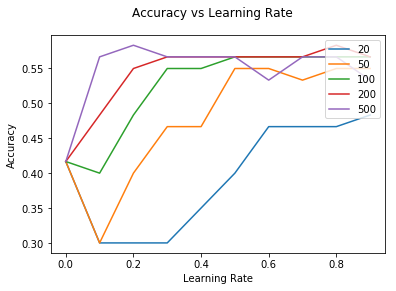

In [14]:
#Question 5.2.5
result=[]
W1=[]
b1=[]
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
giter=[20,50,100,200,500]
for j in giter[:]:
    learning_rate=[]
    result=[]
    for i in range(10):
        learning_rate.append(0.1*i)
        W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.1*i,0.001,j)
        hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
        scores = np.dot(hidden_layer, W2) + b2
        predicted_class = np.argmax(scores, axis=1)
        result.append(np.mean(predicted_class == data_Y_test))    
    plt.plot(learning_rate,result)
    print(j)
plt.suptitle('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend(['20', '50', '100', '200','500'], loc='upper right')
plt.show()

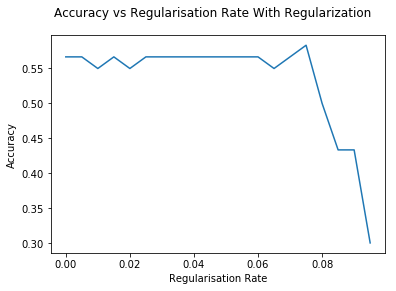

Best Accuracy with Regularization parameter  : 58.33 
Best Regularization parameter with Regularization parameter : 0.07500
Best Accuracy without Regularization parameter  : 56.67 


In [15]:
#Question 5.2.6
accuracy=[]
learning_rate=[]
regu_rate=[]
resultl=[]
W1=[]
b1=[]
resultr=[]
for j in range(20):
    regu_rate.append(0.005*j)
    W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.4,0.005*j,1000)
    hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
    scores = np.dot(hidden_layer, W2) + b2
    predicted_class = np.argmax(scores, axis=1)
    resultr.append(np.mean(predicted_class == data_Y_test))
plt.plot(regu_rate,resultr)
plt.suptitle('Accuracy vs Regularisation Rate With Regularization')
plt.xlabel('Regularisation Rate')
plt.ylabel('Accuracy')
plt.show()
max_acc=max(resultr)
index=resultr.index(max_acc)
print ("Best Accuracy with Regularization parameter  : %.2f " % (max_acc*100))
print ("Best Regularization parameter with Regularization parameter : %.5f" % regu_rate[index])
resultr1=[]
W,b,W2,b2= ffnl(data_X_train,data_Y_train,0.4,0,1000)
hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
scores2 = np.dot(hidden_layer, W2) + b2
predicted_class2 = np.argmax(scores2, axis=1)
resultr1.append(np.mean(predicted_class2 == data_Y_test))
max_acc1=max(resultr1)
index1=resultr1.index(max_acc1)
print ("Best Accuracy without Regularization parameter  : %.2f " % (max_acc1*100))

In [16]:
#Question 5.2.7
data_X_train50, data_X_test50, data_Y_train50, data_Y_test50 = train_test_split(X, y, test_size=0.50)
W,b,W2,b2=ffnl(data_X_train50,data_Y_train50,0.2,0.001,1000)
hidden_layer = np.maximum(np.dot(0.01*data_X_train,W)+b  , np.dot(data_X_train,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('train accuracy with 50:50 split: %.2f' % (np.mean(predicted_class == data_Y_train)*100))

hidden_layer = np.maximum(np.dot(0.01*data_X_test,W)+b  , np.dot(data_X_test,W)+ b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
Test_Acc=(np.mean(predicted_class == data_Y_test)*100)
print ('Test accuracy with 50:50 split: %.2f' % Test_Acc)

train accuracy with 50:50 split: 54.58
Test accuracy with 50:50 split: 65.00
